In [1]:
# Notebook created by Breno Nogueira <RexynyN>

# To install all dependencies
# !pip install tensorflow tensorflow-similarity mtcnn opencv-python numpy matplotlib

import os
import imghdr
import gc
import mtcnn
import cv2
import random 
import numpy as np
import matplotlib.pyplot as plt 
from tabulate import tabulate
from os.path import join as path_join 

# Prevent GPU memory blow-ups 
# (Must run it before importing any tensorflow package)
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import tensorflow as tf
import tensorflow_similarity as tfsim
from tensorflow.keras import layers
from tensorflow_similarity.layers import MetricEmbedding 
from tensorflow_similarity.losses import MultiSimilarityLoss 
from tensorflow_similarity.models import SimilarityModel
from tensorflow_similarity.visualization import viz_neigbors_imgs

2023-10-31 23:45:39.175914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 23:45:41.461832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/breno/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Must have only folders of images (one per class)
IMG_PATH = path_join("training") # BACKUP THESE IMAGES, THEY CAN BE DAMAGED
N_CLASSES = len(os.listdir(IMG_PATH))

# Where preprocessed images will be stored
DATA_PATH = path_join("preprocessed")

# Where invalid or smelly images are sent
TRASH_PATH = path_join("img_trash")

# Reproducibility seed
RAND_SEED = 42

# Tuple with data split (train, test)
DATA_SPLIT = (.8, .2)

# Image's input size (width, height)
# > Tweaking down this value uses less memory (especially if using GPU)
INPUT_SIZE = (400, 400)

# Model Tweaks
EPOCHS = 30

In [3]:
# Configure the memory consumption of a GPU (if any)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
       print(f"Configuring '{gpu}' GPU")
       tf.config.experimental.set_memory_growth(gpu,True)

Configuring 'PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')' GPU


2023-10-31 11:50:10.359685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-31 11:50:10.385743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-31 11:50:10.385837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
# Asserts that the given path exists
def assert_path(path) -> bool:
    is_path = os.path.isdir(path)
    if not is_path:
        os.mkdir(path)
    return is_path

# Remove smelly images
def remove_smelly_images():
    assert_path(TRASH_PATH)
    # All extensions accepted by tensorflow
    whitelist = ("jpg", "jpeg", "png", "bmp", "gif")
    for root, _, files in os.walk(IMG_PATH):
        for name in files:
            filepath = os.path.join(root, name)
            # Guesses what type of image it is
            img_type = imghdr.what(filepath)
            if img_type is None or img_type not in whitelist:
                print(f"{filepath} is a smelly image")
                # Moves to the "trash" directory
                os.rename(filepath, path_join(TRASH_PATH, name))

# remove_smelly_images()

In [10]:
# Preprocess image
detector = mtcnn.MTCNN()

# Get an image from root 
pic = cv2.cvtColor(cv2.imread("arkpatrol.jpg"), cv2.COLOR_BGR2RGB)
roi = detector.detect_faces(pic)

roi[0]

1/1 [==============================] - 0s 166ms/step


{'box': [219, 290, 387, 406],
 'confidence': 0.9997398257255554,
 'keypoints': {'left_eye': (324, 479),
  'right_eye': (469, 419),
  'nose': (420, 575),
  'mouth_left': (409, 641),
  'mouth_right': (531, 592)}}

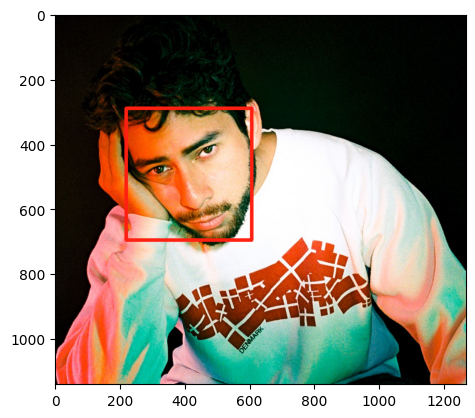

In [11]:
# Create a bounding box to see if the face is being correctly detected
x1, y1, width, height = roi[0]["box"]
x2, y2 = x1 + width, y1 + height

# Draw the box
bounded_face = cv2.rectangle(np.copy(pic), (x1, y1), (x2, y2), (255,32,17), 10)
plt.imshow(bounded_face);

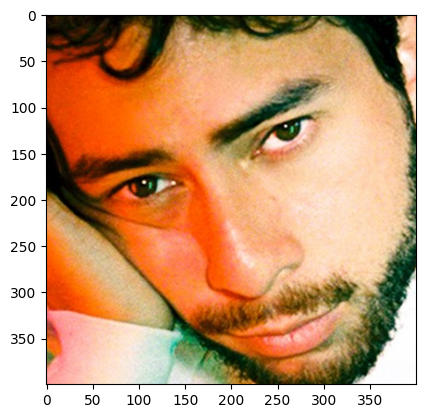

In [12]:
# This is the image we're gonna feed the model
resized = cv2.resize(pic[y1:y2, x1:x2], INPUT_SIZE, interpolation=cv2.INTER_LANCZOS4)
plt.imshow(resized);

In [5]:
# We do this to not memory leak
def clear_oom():
    print("Clearing the Cache and running Garbage Collection")
    gc.collect()
    tf.keras.backend.clear_session()

# Crop all the images to fit just the faces
def classify_dataset():
    # Grants that the trash path exists
    assert_path(TRASH_PATH)
    assert_path(DATA_PATH)

    # Garbage Collection Countdown (no C compiler here for now xD)
    gcc = 0
    for _class in os.listdir(IMG_PATH):
        print(f"Class => {_class}")
        # MTCNN face detector (we reinstantiate it before every reading loop to avoid OOM errors)
        detector = mtcnn.MTCNN()
        clear_oom()
        for img in os.listdir(path_join(IMG_PATH, _class)):
            print(img)
            # Garbage collect and reinstantiate
            if gcc == 300:
                clear_oom()
                detector = mtcnn.MTCNN()
                gcc = 0

            # Load image and detect faces
            pic = cv2.cvtColor(cv2.imread(path_join(IMG_PATH, _class, img)), cv2.COLOR_BGR2RGB)
            roi = detector.detect_faces(pic)
            
            # TODO: Once the model is bootstrapped, we could detect who each person is when len > 1, thus
            # creating an even larger dataset;
            # If there are no faces or more than one, discard the image
            if not roi or len(roi) > 1:
                os.rename(path_join(IMG_PATH, _class, img), path_join(TRASH_PATH, img))
                continue

            # Create a new picture cropping only the face
            x1, y1, width, height = roi[0]["box"]
            x2, y2 = x1 + width, y1 + height
            # Resize to input into our model
            resized = cv2.resize(pic[y1:y2, x1:x2], INPUT_SIZE, interpolation=cv2.INTER_LANCZOS4)
            cv2.imwrite(path_join(DATA_PATH, _class, img), cv2.cvtColor(resized, cv2.COLOR_RGB2BGR))
            gcc += 1
    
    clear_oom()

# classify_dataset()

In [6]:
# Load in the images and labels
labels = []
x_raw_train, y_raw_train = [],[]
for idx, _class in enumerate(os.listdir(DATA_PATH)):
    # Labels to compare the outputs
    labels.append(_class)
    for img in os.listdir(path_join(DATA_PATH, _class)):
        pic = cv2.cvtColor(cv2.imread(path_join(DATA_PATH, _class, img)), cv2.COLOR_BGR2RGB)
        # Append the image and its label
        x_raw_train.append(pic)
        y_raw_train.append(idx)

x_raw_train = np.asarray(x_raw_train)
y_raw_train = np.asarray(y_raw_train)

x_raw_train.shape, y_raw_train.shape

((2511, 400, 400, 3), (2511,))

In [7]:
# Compute the indicies for query, index, val, and train splits
train_idxs, test_idxs = [], []
for cid in range(N_CLASSES):
    # Shuffle the indexes 
    idxs = tf.random.shuffle(tf.where(y_raw_train == cid))
    idxs = tf.reshape(idxs, (-1,))

    # Split the data
    train = int(len(idxs) * DATA_SPLIT[0])
    train_idxs.extend(idxs[:train]) # Training Split
    test_idxs.extend(idxs[train:]) # Testing Split

# Shuffle all the indexes to avoid bias
random.shuffle(train_idxs)
random.shuffle(test_idxs)

2023-10-31 11:50:17.362708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-31 11:50:17.362921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-31 11:50:17.362986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-31 11:50:18.574595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-31 11:50:18.574752: I tensorflow/compile

In [71]:
lis = [123, 400, 400, 3]

lis[0], lis[1:]

(123, [400, 400, 3])

In [8]:
# Return the split as a tf's tensor
def create_split(idxs: list) -> tuple:
    x, y = [], []
    for idx in idxs:
        x.append(x_raw_train[int(idx)])
        y.append(y_raw_train[int(idx)])

    return np.array(x), np.array(y)

x_train, y_train = create_split(train_idxs)
x_test, y_test = create_split(test_idxs)

print(
    tabulate(
        [
            ["train", x_train.shape[0], x_train.shape[1:], y_train.shape],
            ["test", x_test.shape[0], x_test.shape[1:], y_test.shape],
        ],
        headers=["# of Examples", "Image Shape" "# of Labels"],
    )
)

2023-10-31 11:50:20.790463: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 962880000 exceeds 10% of free system memory.


       Examples             Labels
-----  -------------------  --------
train  (2006, 400, 400, 3)  (2006,)
test   (505, 400, 400, 3)   (505,)


In [9]:
# Clear out any old model state.
clear_oom()

# Avoid GPU memory blow up
# tfsim.utils.tf_cap_memory()  

# Build a Similarity model using standard Keras layers
inputs = layers.Input(shape=(INPUT_SIZE[0], INPUT_SIZE[1], 3))
x = layers.Rescaling(1/255)(inputs)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
outputs = MetricEmbedding(64)(x)

# Build a specialized Similarity model
model = SimilarityModel(inputs, outputs)

model.summary()

Clearing the Cache and running Garbage Collection


Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 398, 398, 32)      896       
                                                                 
 flatten (Flatten)           (None, 5068928)           0         
                                                                 
 dense (Dense)               (None, 32)                162205728 
                                                                 
 metric_embedding (MetricEm  (None, 64)                2112      
 bedding)                                                        
                                                  

In [10]:
# Train Similarity model using contrastive loss
model.compile('adam', loss=MultiSimilarityLoss())
model.fit(x_train, y_train, epochs=EPOCHS)

Distance metric automatically set to cosine use the distance arg to override.


2023-10-31 11:50:22.531278: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 962880000 exceeds 10% of free system memory.


Epoch 1/30


2023-10-31 11:50:28.785665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-10-31 11:50:55.978493: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd0e59332b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-31 11:50:55.978546: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2023-10-31 11:50:56.150419: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-31 11:50:56.945071: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 [==============================] - 230s 3s/step - loss: 1.0268
Epoch 2/30
63/63 [==============================] - 164s 3s/step - loss: 1.0083
Epoch 3/30
63/63 [==============================] - 164s 3s/step - loss: 0.9688
Epoch 4/30
63/63 [==============================] - 168s 3s/step - loss: 0.9237
Epoch 5/30
63/63 [==============================] - 163s 3s/step - loss: 0.8532
Epoch 6/30
63/63 [==============================] - 167s 3s/step - loss: 0.7841
Epoch 7/30
63/63 [==============================] - 162s 3s/step - loss: 0.6538
Epoch 8/30
63/63 [==============================] - 165s 3s/step - loss: 0.5874
Epoch 9/30
63/63 [==============================] - 160s 3s/step - loss: 0.5114
Epoch 10/30
63/63 [==============================] - 164s 3s/step - loss: 0.4256
Epoch 11/30
63/63 [==============================] - 159s 3s/step - loss: 0.3360
Epoch 12/30
63/63 [==============================] - 165s 3s/step - loss: 0.2611
Epoch 13/30
63/63 [=============================

In [11]:
# Index a part of our dataset so we can query it
sx, sy = x_test[:100], y_test[:100]
model.index(x=sx, y=sy, data=sx)

[Indexing 100 points]
|-Computing embeddings
4/4 [==============================] - 6s 2s/step
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.



0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


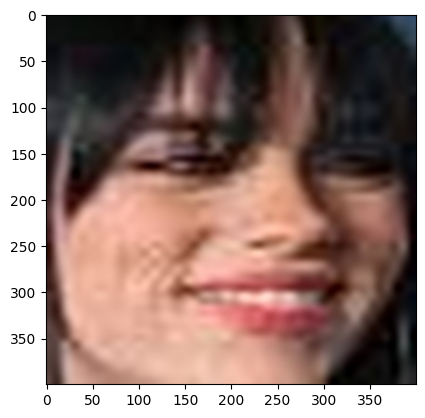

In [41]:
# imgn = 247
imgn = 42

# Get an example image to find in the indexed images
qx, qy = x_test[imgn], y_test[imgn] 
plt.imshow(qx);

1/1 [==============================] - 0s 32ms/step


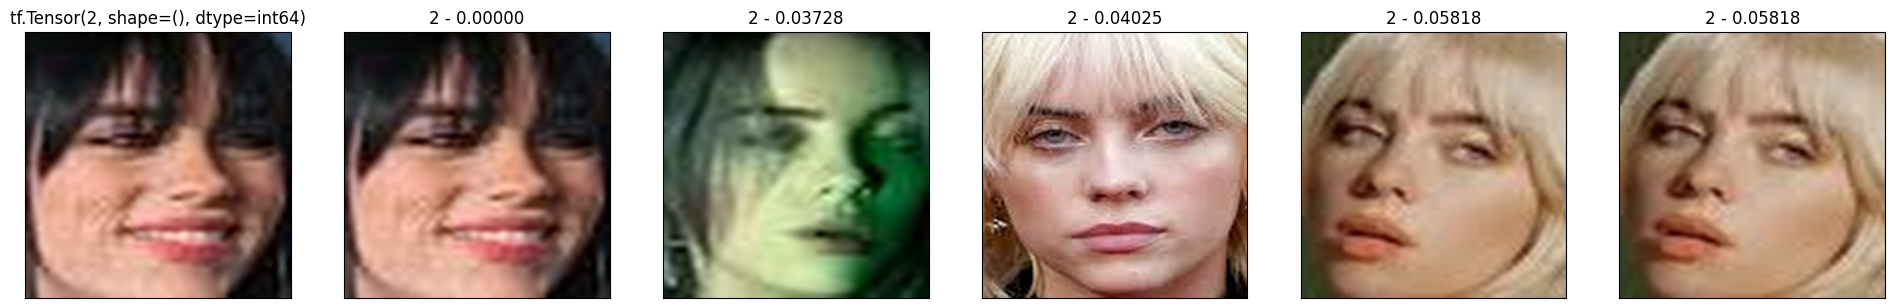

In [42]:
# Get "k" nearest neighbors
knns = model.single_lookup(qx, k=5)

# Visualize the query example and its top 5 neighbors
viz_neigbors_imgs(qx, qy, knns)

In [53]:
# Calibrate the model
calibration = model.calibrate(
    x_test,
    y_test,
    extra_metrics=["precision", "recall", "binary_accuracy"],
    verbose=1
)

32/32 [==============================] - 42s 1s/step

Performing NN search



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 182.59it/s]


 name        value    distance    precision    recall    binary_accuracy        f1
-------  --------  ----------  -----------  --------  -----------------  --------
optimal  0.991919    0.271525     0.983968         1              0.982  0.991919


In [56]:
# Match the face to a label
pred = np.reshape(qx, (-1, INPUT_SIZE[0], INPUT_SIZE[1], 3))
match_pred = model.match(pred)[0]

# Convert the int value of the label to its name
labels[match_pred]

1/1 [==============================] - 0s 35ms/step


'billie_eilish'

In [58]:
# No idea why it only works wrapping the path on dirname(), but here we are
# Saves the model in a .h5 file to later use
# model.save(os.path.dirname("facial_recon.h5"))

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 153ms/step


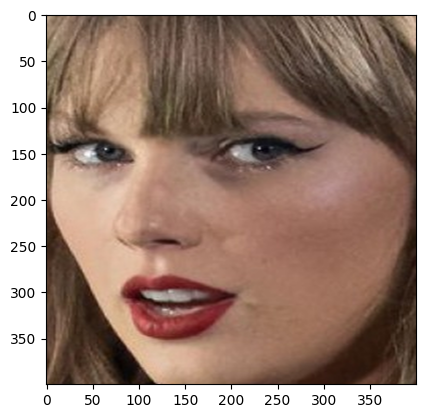

In [73]:
def preprocess_image(path):
    detector = mtcnn.MTCNN()
    # Load image and detect faces
    pic = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    roi = detector.detect_faces(pic)

    # Create a new picture cropping only the face
    x1, y1, width, height = roi[0]["box"]
    x2, y2 = x1 + width, y1 + height

    return cv2.resize(pic[y1:y2, x1:x2], INPUT_SIZE, interpolation=cv2.INTER_LANCZOS4)

test = preprocess_image("unknown.jpg")
plt.imshow(test);

In [74]:
labels[model.match(pred)[0]]

1/1 [==============================] - 0s 38ms/step


'billie_eilish'